In [ ]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchsummary
import torch.nn as nn

from torch.nn.modules.normalization import LocalResponseNorm
from torch.utils.data import random_split
from torch import optim
from sklearn.metrics import confusion_matrix # 오차행렬을 통해서 recall, precision, f1-score 구하기

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Device와 seed값 설정

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(0)

if device == 'cuda':
  torch.cuda.manual_seed(0)

print('Device : ',device)

Device :  cuda


In [ ]:
# == Cifar10 데이터 얻기 ==
def get_data(flag = True):
    train = dsets.CIFAR10(root = '/data',
                          train = True,
                          download = True)
    test = dsets.CIFAR10(root = '/data',
                        train = False,
                        download = True)
    return train, test

## Train, Test 이미지들 확인



In [ ]:
train, test = get_data()

100%|██████████| 170498071/170498071 [00:03<00:00, 42880501.62it/s]


Extracting /data/cifar-10-python.tar.gz to /data
Files already downloaded and verified


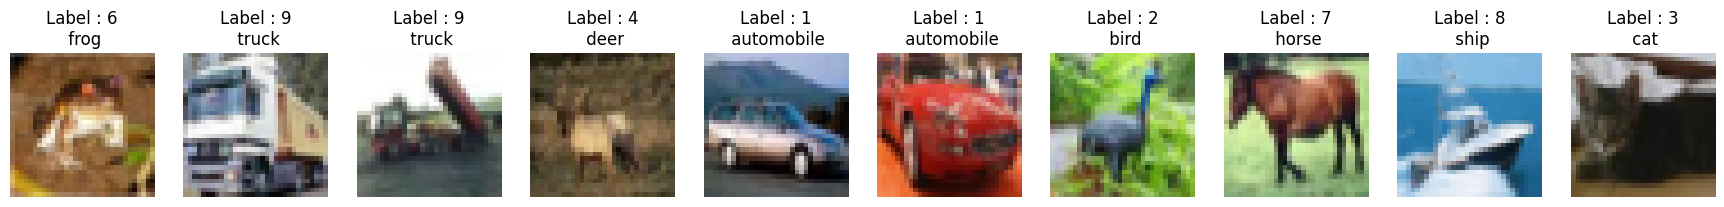

In [ ]:
# Cifar10 이미지 확인

# == train에 대한 label 뽑기 ==
train_labels_dict = train.class_to_idx
train_labels_dict = dict(zip(train_labels_dict.values(), train_labels_dict.keys()))

# == 10개의 train 봐보기 ==
train_images, train_labels = train.data[:10], train.targets[:10]

# == img들 볼 수 있는 함수 ==
def show_img(img, label, count = 10, flag = True):
  figure, axs = plt.subplots(figsize = (22, 6), nrows = 1, ncols = count)

  for i in range(count):
    axs[i].imshow(img[i])

    # == Train ==
    if flag == True:
      axs[i].set_title(f"Label : {train_labels[i]}\n {train_labels_dict[train_labels[i]]}")

    # == Test ==
    elif flag == False:
      axs[i].set_title(f"Label : {test_labels[i]}\n {test_labels_dict[test_labels[i]]}")

    axs[i].axis('off')

# == train 이미지 확인==
show_img(train_images,train_labels, count = 10, flag = True)

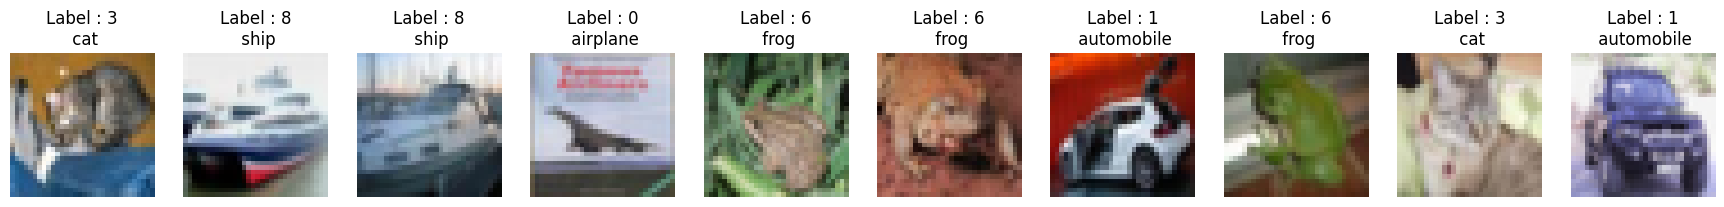

In [ ]:
# Cifar 10 이미지 확인

# == test에 대한 label 뽑기 ==
test_labels_dict = test.class_to_idx
test_labels_dict = dict(zip(test_labels_dict.values(), test_labels_dict.keys()))

# == 10개의 test 봐보기 ==
test_images, test_labels = test.data[:10], test.targets[:10]

# == test 이미지 확인 ==
show_img(test_images, test_labels, count = 10, flag = False)


# 데이터 전처리

In [ ]:
train, test = get_data()

train.transform = transforms.ToTensor()
test.transform = transforms.ToTensor()

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# == 이미지의 전처리 작업으로 Image의 각 channel의 평균값을 빼주었다고 한다. ==

# == 이미지 전처리 ==

# == Train ==

meanRGB_train = [np.mean(x.numpy(), axis = (1, 2)) for x, _ in train] # criterion by row, column --> become RGB mean
stdRGB_train = [np.std(x.numpy(), axis = (1, 2)) for x, _ in train]

meanRGB_test = [np.mean(x.numpy(), axis = (1, 2)) for x, _ in test] # criterion by row, column --> become RGB mean
stdRGB_test = [np.std(x.numpy(), axis = (1, 2)) for x, _ in test]

meanR_train = np.mean([m[0] for m in meanRGB_train])
meanG_train = np.mean([m[1] for m in meanRGB_train])
meanB_train = np.mean([m[2] for m in meanRGB_train])

stdR_train = np.mean([s[0] for s in stdRGB_train])
stdG_train = np.mean([s[1] for s in stdRGB_train])
stdB_train = np.mean([s[2] for s in stdRGB_train])

mean_train = [meanR_train, meanG_train, meanB_train]
std_train = [stdR_train, stdG_train, stdB_train]

# == Test ==
meanR_test = np.mean([m[0] for m in meanRGB_test])
meanG_test = np.mean([m[1] for m in meanRGB_test])
meanB_test = np.mean([m[2] for m in meanRGB_test])

stdR_test = np.mean([s[0] for s in stdRGB_test])
stdG_test = np.mean([s[1] for s in stdRGB_test])
stdB_test = np.mean([s[2] for s in stdRGB_test])

mean_test = [meanR_test, meanG_test, meanB_test]
std_test = [stdR_test, stdG_test, stdB_test]

print(' == == == == Train == == == ==')
print('각 Channel당 pixel Mean 값 : ', mean_train)
print('각 Channel당 pixel Std 값 : ', std_train)
print(' == == == == == == == == == ==')

print(' == == == == Test == == == ==')
print('각 Channel당 pixel Mean 값 : ', mean_test)
print('각 Channel당 pixel Std 값 : ', std_test)
print(' == == == == == == == == == ==')

 == == == == Train == == == ==
각 Channel당 pixel Mean 값 :  [0.49139965, 0.48215845, 0.4465309]
각 Channel당 pixel Std 값 :  [0.20220213, 0.19931543, 0.20086348]
 == == == == == == == == == ==
 == == == == Test == == == ==
각 Channel당 pixel Mean 값 :  [0.49421427, 0.48513138, 0.45040908]
각 Channel당 pixel Std 값 :  [0.20189482, 0.19902097, 0.20103233]
 == == == == == == == == == ==


In [ ]:
'''
== train loader & augmentation ==
1. cifar10의 size는 32x32이기 때문에 256x256으로 resize를 해주는 것이 아닌 28x28로 resize
2. Random crop : 무작위로 자르는 데 사용
3. Translation : 각도는 변하지 않고, 수평,수직 방향으로 최대 10%로 이동할 수 있게끔 한다.
4. Horizontal flip : 50%로 수평변환
5. Normalization : mean값 각 channel의 평균값을 빼주기, std에 대한 이야기는 없었음
6. PCA가 있긴함.

== test loader &  ==
1. 28x28로 resize
2. Normalization
'''
train_loader = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256)),
    transforms.CenterCrop((227)),
    transforms.RandomAffine(degrees = 0, translate = (0.1, 0.1)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.Normalize(mean_train, std_train)

])

test_loader = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((227)),
    transforms.Normalize(mean_test, std_test)
])
train.transform = train_loader
test.transform = test_loader

# 모델 설계

In [ ]:
class Alex(nn.Module):
  def __init__(self):
    super(Alex, self).__init__()

    # input size : 3 * 227 * 227

    # Conv Layer
    self.conv = nn.Sequential(

        # Layer 1
        nn.Conv2d(in_channels = 3, out_channels = 96, kernel_size = 11, stride = 4, padding = 0),
        nn.BatchNorm2d(96),
        nn.ReLU(),
        # nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75, k = 2),
        nn.MaxPool2d(kernel_size = 3, stride = 2),

        # Layer 2
        nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2), # (b x 256 x 27 x 27)  !!!!!!!!!!!!!!!![4]
        nn.BatchNorm2d(256),
        nn.ReLU(),
        # nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
        nn.MaxPool2d(kernel_size=3, stride=2),

        # Layer 3
        nn.Conv2d(256, 256, 3, 1, 1, groups = 256),# [8]
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(256, 384, 3, 1, 1),# [11]
        nn.ReLU(),

        # Layer 4
        # nn.Conv2d(384, 384, 3, 1, 1),
        nn.Conv2d(384, 384, 3, 1, 1, groups = 384), # depth wise conv # [13]
        nn.ReLU(),

        # Layer 5
        nn.Conv2d(384, 256, 3, 1, 1), # [15]
        nn.ReLU(),
        nn.MaxPool2d(3, 2)
    )

    self.fc = nn.Sequential(

        # Fc 1
        nn.Linear(256 * 6 * 6, 4096),
        nn.ReLU(),
        nn.Dropout(p = 0.5),

        # Fc 2
        nn.Linear(4096, 4096),
        nn.ReLU(),
        nn.Dropout(p = 0.5),
    )
    # output layer
    self.outlayer = nn.Linear(4096, 10)

  # weight initialized
  def init_weight(self):
      for layer in self.modules():
          if isinstance(layer, (nn.Conv2d, nn.Linear)):
              nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')
      nn.init.xavier_uniform_(self.outlayer.weight)

  # model sequence
  def forward(self, x):
    out = self.conv(x)

    # flatten
    out = out.view(out.size(0), -1)
    out = self.fc(out)

    return out

In [ ]:
# == 모델 봐보기 ==

model = Alex().to(device)

model.init_weight()

torchsummary.summary(model, input_size = (3, 227, 227), device = 'cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
       BatchNorm2d-2           [-1, 96, 55, 55]             192
              ReLU-3           [-1, 96, 55, 55]               0
         MaxPool2d-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]         614,656
       BatchNorm2d-6          [-1, 256, 27, 27]             512
              ReLU-7          [-1, 256, 27, 27]               0
         MaxPool2d-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]           2,560
      BatchNorm2d-10          [-1, 256, 13, 13]             512
             ReLU-11          [-1, 256, 13, 13]               0
           Conv2d-12          [-1, 384, 13, 13]         885,120
             ReLU-13          [-1, 384, 13, 13]               0
           Conv2d-14          [-1, 384,

# 훈련&검증

In [ ]:
# == train : 80%, validation : 20% ==

train_ratio = 0.8
val_ratio = 0.2

train_size = int(len(train) * train_ratio)
val_size = len(train) - train_size

split_train, split_val = random_split(train, [train_size, val_size])

In [ ]:
# == 논문 그대로 설정 ==
batch_size = 128
learning_rate = 0.01
epochs = 10 # for real, epoch = 90
momentum = 0.9
weight_decay = 0.0005

In [ ]:
# == 최적화, 손실함수 ==
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = momentum, weight_decay = weight_decay)
criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset = split_train,
                                           batch_size=  batch_size,
                                           shuffle = True,
                                           drop_last = True)

val_loader = torch.utils.data.DataLoader(dataset = split_val,
                                        batch_size = batch_size,
                                        shuffle = True,
                                        drop_last = True)

In [ ]:
total_batch = len(train_loader)

print('Weight update 횟수 : ', total_batch)

Weight update 횟수 :  312


In [ ]:
# == Confusion Matrix ==
y_true = []
y_pred = []

# == Loss ==
train_losses = []
validation_losses = []

# == Accuracy ==
train_accuracy = []
validation_accuracy = []

# == Weight 저장 ==
best_model_path = "best_weight_AlexNet_first.pth"
best_accuracy = 0.0

In [ ]:
train_losses = []
validation_losses = []

train_accuracy = []
validation_accuracy = []

# == 학습 진행 ==
for epoch in range(epochs):
    # == 모델을 학습 모드로 설정 ==
    model.train()
    '''
    1. for문 1번 반복할때마다 batch_idx는 batch_size만큼 증가
     ex) 1 iter: 0 ~ 127
         2 iter: 128 ~ 255
         전체 훈련 데이터를 다 쓰기전까지 반복.
    '''


    # train loss 변수
    running_train_loss = 0.0

    correct_train = 0
    total_train = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        # 데이터와 레이블을 GPU로 이동 (if available)
        data, target = data.to(device), target.to(device)

        # Forward 연산
        output = model(data)

        # Confusion Matrix
        _, predicted = torch.max(output, 1)
        y_true.extend(target.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

        # 손실 계산
        loss = criterion(output, target)

        # Backward 연산 및 매개변수 업데이트
        optimizer.zero_grad() # 미분값 중복 방지
        loss.backward() # 오차역전파
        optimizer.step() # parameter 업데이트

        # train loss 담기
        running_train_loss += loss.item()

        # 일정 간격으로 손실 출력
        if batch_idx % 100 == 0:
            #print(len(train_loader)) 항상 312로 동일한 값
            print(batch_idx)
            print('Epoch {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())) # 100.은 실수형을 말한다.(실수형으로 출력하기 위함)
                # len(train_loader)는 배치 개수를 나타낸다. 여기서는 312개(312번 가중치 update)

        pred_train = output.argmax(dim=1, keepdim=True)
        correct_train += pred_train.eq(target.view_as(pred_train)).sum().item()
        total_train += data.size(0)  # 현재 배치의 데이터 수를 더함

    # 전체 훈련 데이터에 대한 정확도 계산 및 저장
    accuracy_train = 100. * correct_train / total_train
    train_accuracy.append(accuracy_train)  # train accuracy 기록

    # train loss 기록
    train_loss = running_train_loss / len(train_loader) # 모든 batch의 평균 훈련 손실
    train_losses.append(train_loss)


    # == 검증 데이터셋을 사용한 모델 평가 ==

    # ==  모델을 평가 모드로 설정 ==
    model.eval()
    val_loss = 0
    correct = 0

    # == 미분값 계산 x ==
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)

            # Forward 계산
            output = model(data)

            val_loss += criterion(output, target).item() # 손실함수 계산
            pred = output.argmax(dim=1, keepdim=True) # 예측값(행마다)에서 가장 큰 값의 인덱스 가져옴, (n, 1)형식
            correct += pred.eq(target.view_as(pred)).sum().item() # target을 pred와 같은 shape으로 만들어준다.
            '''
            .eq()는 두 tensor의 shape이 동일해야 비교 연산이 가능하다.
            '''
    validation_losses.append(val_loss / len(val_loader)) # validation loss 기록
    val_loss /= len(val_loader.dataset) # 검증 손실함수
    val_accuracy = 100. * correct / len(val_loader.dataset) # 검증 정확도

    # == 가중치 저장 ==
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), best_model_path)
        print(f"Weight Updated {best_accuracy}")
    validation_accuracy.append(val_accuracy) # validation accuracy 기록


    # == 검증 결과 출력 ==
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        val_loss, correct, len(val_loader.dataset), val_accuracy))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


0
Epoch 1 [0/40000 (0%)]	Loss: 13.784113
100
Epoch 1 [12800/40000 (32%)]	Loss: 6.622264
200
Epoch 1 [25600/40000 (64%)]	Loss: 5.948086
300
Epoch 1 [38400/40000 (96%)]	Loss: 5.466837
Weight Updated 38.49

Validation set: Average loss: 0.0414, Accuracy: 3849/10000 (38.49%)

0
Epoch 2 [0/40000 (0%)]	Loss: 5.571911
100
Epoch 2 [12800/40000 (32%)]	Loss: 5.859042
200
Epoch 2 [25600/40000 (64%)]	Loss: 5.499863
300
Epoch 2 [38400/40000 (96%)]	Loss: 5.511615
Weight Updated 45.61

Validation set: Average loss: 0.0385, Accuracy: 4561/10000 (45.61%)

0
Epoch 3 [0/40000 (0%)]	Loss: 5.463805
100
Epoch 3 [12800/40000 (32%)]	Loss: 5.612221
200
Epoch 3 [25600/40000 (64%)]	Loss: 5.453449
300
Epoch 3 [38400/40000 (96%)]	Loss: 5.666025
Weight Updated 49.52

Validation set: Average loss: 0.0383, Accuracy: 4952/10000 (49.52%)

0
Epoch 4 [0/40000 (0%)]	Loss: 5.453957
100
Epoch 4 [12800/40000 (32%)]	Loss: 5.328113
200
Epoch 4 [25600/40000 (64%)]	Loss: 5.527386
300
Epoch 4 [38400/40000 (96%)]	Loss: 5.661595
We

# 모델 테스트

In [ ]:
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1) # 가장 높은값의 인덱스, 값 반환 --> 여기서는 가장 높은 값만 반환했다.

    total += labels.size(0) # 전체 데이터 예측 개수(len(cifar_test_loader) 와 같다)
    correct += (predicted == labels.to(torch.long)).sum().item() # predicted, labels의 텐서 타입이 일치하지 않아서 long으로 바꾸어줌.
    # 맞으면 correct에 true, 틀리면 false 반환한다. 맞은 것만 개수 센다.

accuracy = 100 * correct / total
print(f'Accuracy : {accuracy}')

Accuracy : 63.37


# Confusion Matrix 구현

In [ ]:
# == Confusion Matrix 출력 ==
conf_matrix = confusion_matrix(y_true, y_pred)

print('Confusion Matrix : ')
print(conf_matrix)

Confusion Matrix : 
[[14845     4  5005 ...     0     0     1]
 [ 7772     7  2424 ...     1     0     0]
 [ 3649     4 11927 ...     0     0     0]
 ...
 [    0     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0     0]]


In [ ]:
# 클래스의 이름을 정의 (CIFAR-10의 경우)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Confusion matrix 시각화
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # 폰트 크기 설정

# Confusion matrix 히트맵 생성
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


'''
1. Recall
2. Precision
3. F1-score 구해보기


'''

KeyboardInterrupt: ignored

Error in callback <function _draw_all_if_interactive at 0x7951ea1e9fc0> (for post_execute):


KeyboardInterrupt: ignored

# train_loss와 validation_loss 시각화

In [ ]:
def loss_visualization(train_loss, val_loss):

  plt.figure(figsize = (8, 6))
  plt.plot(train_losses, label = 'train_loss', marker = 'o')
  plt.plot(val_loss, label = 'val_loss', marker = 's')
  plt.title('Train Loss & Validaiton Loss')
  plt.xticks(np.arange(0, len(train_loss)))
  plt.xlabel('Epoch')
  plt.ylabel('Loss(Cross Entropy)')
  plt.legend()
  plt.tight_layout()
  plt.show()

In [ ]:
loss_visualization(train_losses, validation_losses)


'''
overfitting 나지 않음

'''

# train_accuracy와 validation_accuracy 시각화

In [ ]:
def acc_visualization(train_acc, val_acc):
  plt.figure(figsize = (8, 6))
  plt.plot(train_acc, label = 'train_acc', marker = 'o', ls = '--')
  plt.plot(val_acc, label = 'val_acc', marker = 's')
  plt.title('Train Accuracy & Validaiton Accuracy')
  plt.xticks(np.arange(0, epochs, step=max(1, epochs // 10)))
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [ ]:
acc_visualization(train_accuracy, validation_accuracy)

'''
overfitting x

'''

# PCA 코드를 통해서 class별 embedding space 표현

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler # PCA는 Normalization하면 좌표로 더 잘볼 수 있다.

In [ ]:
model.eval()

images, labels = next(iter(test_loader))
images = images.to(device)  # 이미 GPU로 로드된 모델의 가중치와 동일한 장치로 데이터 이동
labels = labels.numpy()

# AlexNet을 통과한 후의 특성 추출
with torch.no_grad():
    outputs = model(images)

# PCA를 통한 2차원으로의 축소
pca = PCA(n_components=2)
pca_result = pca.fit_transform(outputs.cpu().numpy())  # PCA는 CPU에서 수행됨

# 클래스 별로 embedding space 시각화
plt.figure(figsize=(10, 8))
for i in range(10):  # CIFAR-10에는 총 10개의 클래스가 있음
    indices = np.where(labels == i)
    plt.scatter(pca_result[indices, 0], pca_result[indices, 1], label=f'Class {i}')
plt.legend()
plt.title('Cifar10-Embedding Image Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()
